In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp

from function_approximation import rbf, approx_nonlin_func, rbf_approx

In [2]:
df = pd.read_csv('MI_timesteps.txt', sep=' ')

### Task 1

In [3]:
delays = 351 # including the undelayed data point

x_original = df.to_numpy()[1000:]
x_original = x_original[: len(x_original) - (len(x_original) % delays)]

x = np.array([x_original[i : i + delays, 1:4].flatten() for i in range(len(x_original) - delays + 1)])

pca = PCA(3)
x_pca = pca.fit_transform(x)

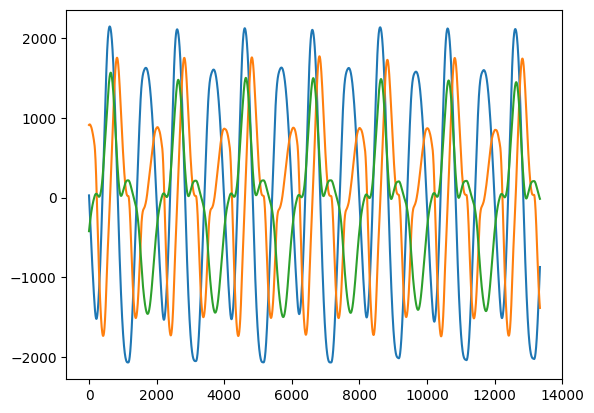

In [4]:

for i in range(x_pca.shape[1]):
    plt.plot(x_pca[:,i])

### Task 2

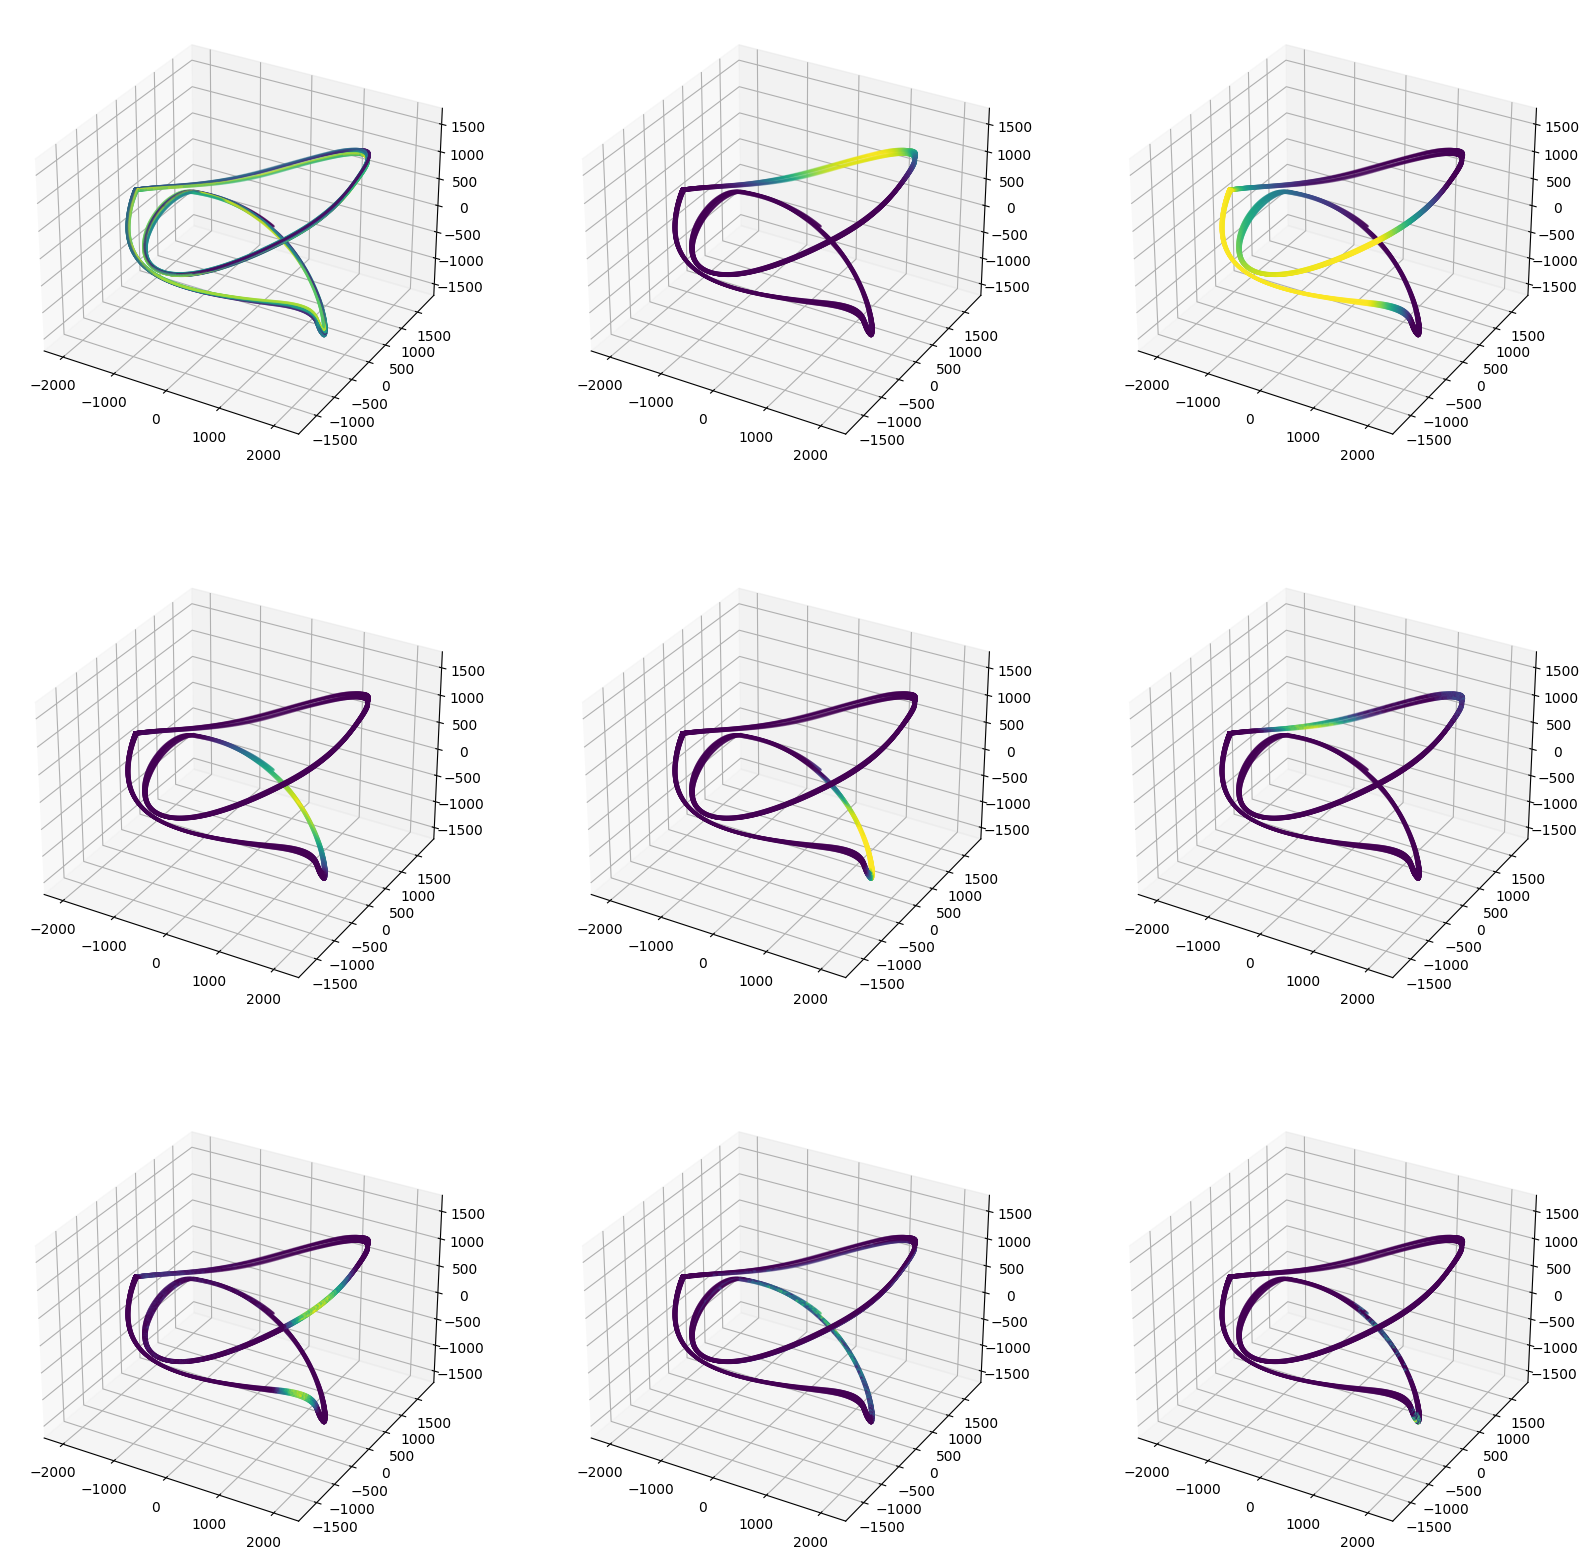

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), subplot_kw=dict(projection='3d'))

for i in range(9):
    axs[i // 3][i % 3].scatter(*x_pca.T, s=1, c=x_original[: len(x_original) - delays + 1, i])

plt.show()

### Task 3

There are roughly 7 complete periods in the data. In the following we take a look at the first period.

In [6]:
lowest_dist, lowest_dist_idx = np.inf, -1
for i in range(x_pca.shape[0] -1):
    attempt_lowest_dist = np.linalg.norm(x_pca[i]-x_pca[0])
    if attempt_lowest_dist < lowest_dist and i > 100:
        lowest_dist = attempt_lowest_dist
        lowest_dist_idx = i

In [7]:
arclens = [] 
v = [] 
arclen = 0 
for i in range(lowest_dist_idx):
    arclen += np.linalg.norm(x_pca[i + 1] - x_pca[i])

    arclens.append(arclen)
    v.append(arclen / (i + 1))

arclens = np.array(arclens)
v = np.array(v)
n = len(v)

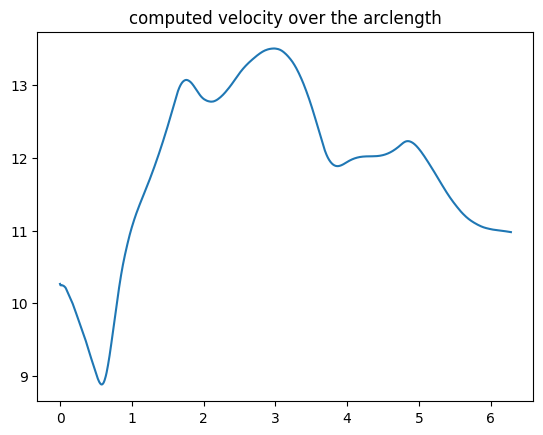

In [8]:
idxs = np.linspace(0, 2 * np.pi, len(v))
plt.plot(idxs, v)
plt.title('computed velocity over the arclength')
plt.show()

In [9]:
centers = np.random.choice(arclens, replace=False, size=1000)[:, np.newaxis]
v = v[:, np.newaxis]
arclens = arclens[:, np.newaxis]

C, res, _, _, phi = approx_nonlin_func(data=(arclens, v), eps=100, centers=centers)

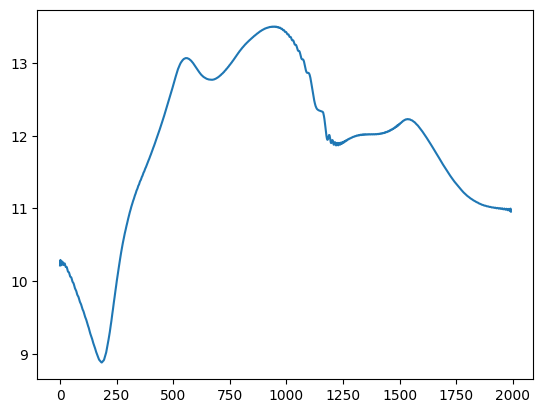

In [10]:
plt.plot(phi @ C)

### Task 4

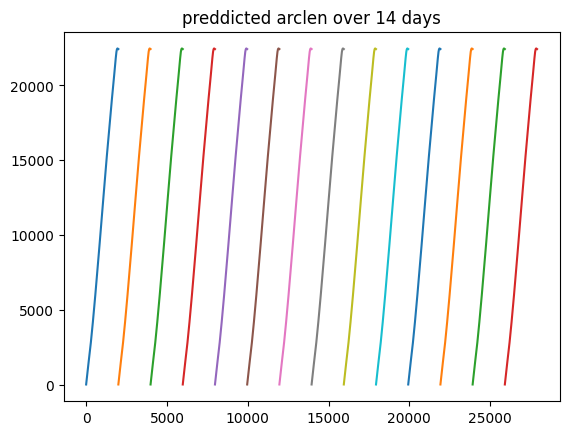

In [11]:
start_arclen = arclens[0]
predicted_arclens = []
for i in range(14):
    t_eval = np.linspace(0, n, n)
    
    sol = solve_ivp(rbf_approx, [0, n],  start_arclen, t_eval = t_eval, args=[centers, 100, C])
    sol.t = sol.t + i * n

    predicted_arclens.append(sol.y[0,:])
    plt.plot(sol.t, sol.y[0,:])

plt.title("preddicted arclen over 14 days")
predicted_arclens = np.array(predicted_arclens).flatten()[:, np.newaxis]

In [12]:
arclens = predicted_arclens[: x_original.shape[0]]
occupancy = x_original[:, 1][:, np.newaxis]

centers = np.random.choice(arclens.squeeze(), replace=False, size=1000)[:, np.newaxis]

C, res, _, _, phi = approx_nonlin_func(data=(arclens, occupancy), eps=100, centers=centers)

Text(0.5, 1.0, 'predicted occupancy over 7 days')

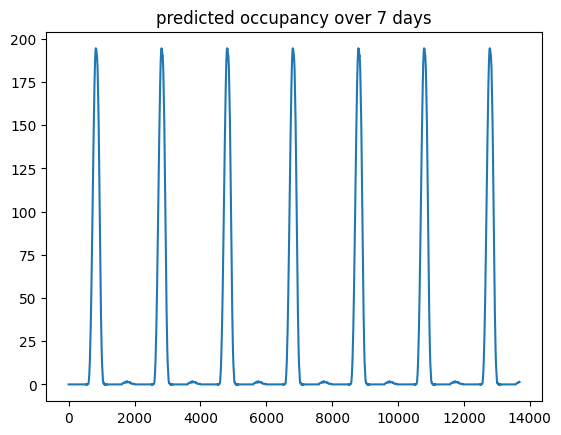

In [13]:
plt.plot(phi@C)
plt.title("predicted occupancy over 7 days")

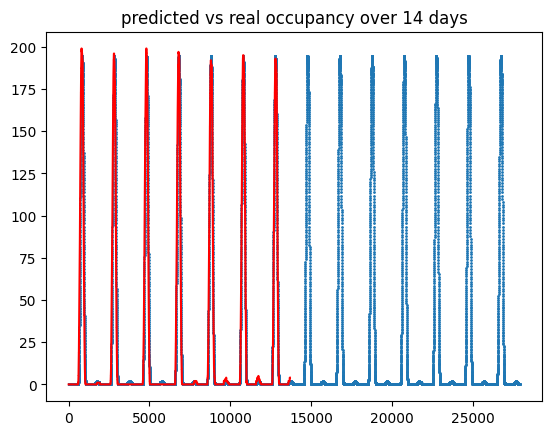

In [15]:
phis = []

for i in range(len(predicted_arclens)):
    single_phi = rbf(predicted_arclens[i, np.newaxis], centers, 100)
    phis.append(single_phi @ C)

plt.scatter(range(len(predicted_arclens)), phis, s=1)
plt.plot(occupancy, c='red')
plt.title("predicted vs real occupancy over 14 days")
plt.show()